<a href="https://colab.research.google.com/github/PaSathees/random-notebooks/blob/main/PyTorch_Transfer_learning_testing_with_modularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[PyTorch course notebook](https://github.com/PaSathees/ai-courses/blob/main/3.%20PYTORCH%20-%20UDEMY/6.%20PyTorch%20Transfer%20Learning/06_pytorch_transfer_learning.ipynb)

[Modular code repo](https://github.com/PaSathees/pytorch-bp)

# 1. Imports and environment setup

In [1]:
# Getting modue
!rm -rf pytorch_mod
!git clone https://github.com/PaSathees/pytorch_mod.git

Cloning into 'pytorch_mod'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 127 (delta 75), reused 78 (delta 33), pack-reused 0
Receiving objects: 100% (127/127), 32.44 KiB | 4.63 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [29]:
pip install -r pytorch_mod/requirements.txt --quiet

In [3]:
from pytorch_mod import env_setup, data_setup, engine, evaluation, utils, visualization, experimentation, deployment, cv_model_builders

In [4]:
env_setup.print_gpu_status()

1 Supported CUDA GPU are available


In [5]:
device = env_setup.get_agnostic_device()
device

'cuda'

In [6]:
env_setup.print_versions()

PyTorch Version: 2.0.1+cu118
Matplotlib Version: 3.7.1
Pandas Version: 1.5.3
Numpy Version: 1.23.5
Torchvision Version: 0.15.2+cu118
Torchaudio Version: 2.0.2+cu118
Scikit-learn Version: 1.2.2
Torchmetrics Version: 1.1.1
TQDM Version: 4.66.1
MLEXTEND Version: 0.22.0
PIL Version: 9.4.0
Torchinfo Version: 1.8.0
Gradio Version: 3.43.1


In [7]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchinfo import summary

# 2. Getting data
Data is from the course given in a zip file.

No need to bother with the problem as this is only testing modularized code.

In [8]:
image_path = utils.download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
    remove_source = True
)

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"

# 3. Creating dataloaders

In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
train_dataloader, test_dataloader, class_names = data_setup.create_cv_dataloaders(train_dir=train_dir,
                                                                       test_dir=test_dir,
                                                                       transform=auto_transforms,
                                                                       batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b6a57a94c70>,
 ['pizza', 'steak', 'sushi'])

In [13]:
# Testing with val_dataloader
# train_dataloader, val_dataloader, test_dataloader, class_names = create_cv_dataloaders(train_dir=train_dir,
#                                                                        test_dir=test_dir,
#                                                                        val_dir=test_dir,
#                                                                        transform=auto_transforms,
#                                                                        batch_size=32)

# train_dataloader, val_dataloader, test_dataloader, class_names

# 4. Getting Pre-trained model

In [14]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 271MB/s]


In [15]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [16]:
# Freeze features
for param in model.features.parameters():
  param.requires_grad = False

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [18]:
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 5. Training Model

In [19]:
# Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
utils.set_seeds()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       val_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

[INFO] Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

[INFO] Epoch: 1 | Train_loss: 1.0924 | Train_acc: 0.3984 | Val_loss: 0.9133 | Val_acc: 0.5398
[INFO] Epoch: 2 | Train_loss: 0.8717 | Train_acc: 0.7773 | Val_loss: 0.7912 | Val_acc: 0.8153
[INFO] Epoch: 3 | Train_loss: 0.7648 | Train_acc: 0.7930 | Val_loss: 0.7463 | Val_acc: 0.8561
[INFO] Epoch: 4 | Train_loss: 0.7109 | Train_acc: 0.7539 | Val_loss: 0.6373 | Val_acc: 0.8655
[INFO] Epoch: 5 | Train_loss: 0.6255 | Train_acc: 0.7852 | Val_loss: 0.6261 | Val_acc: 0.8561
[INFO] Training time: 13.604 seconds


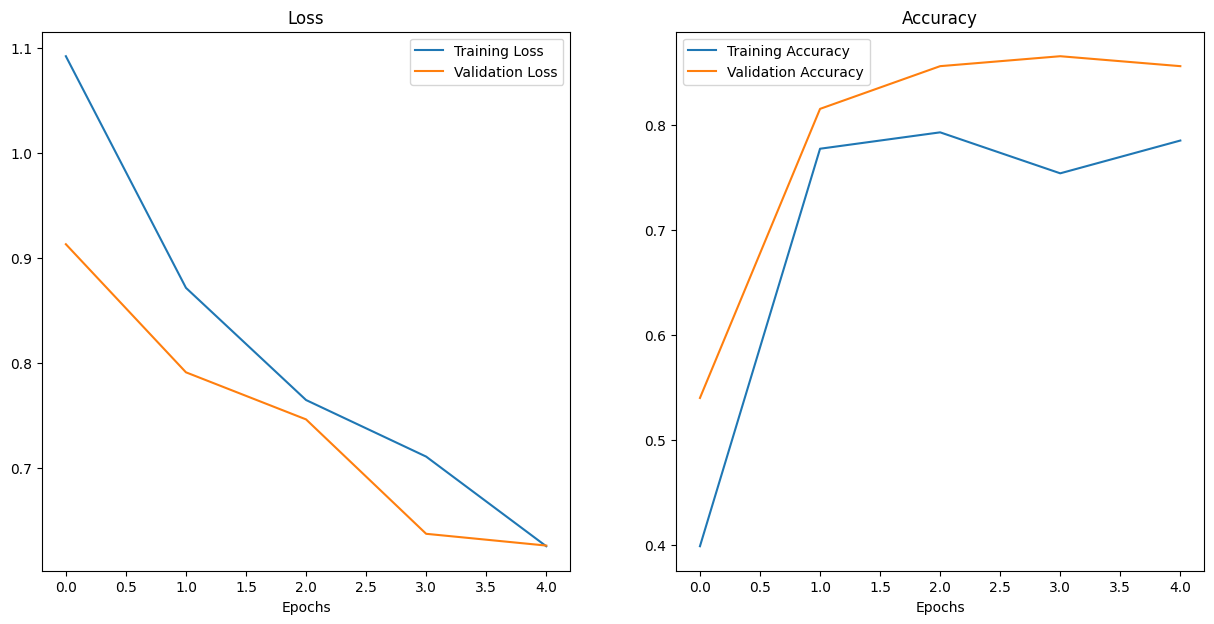

In [21]:
visualization.plot_curves(results)

# 6. Making Predictions

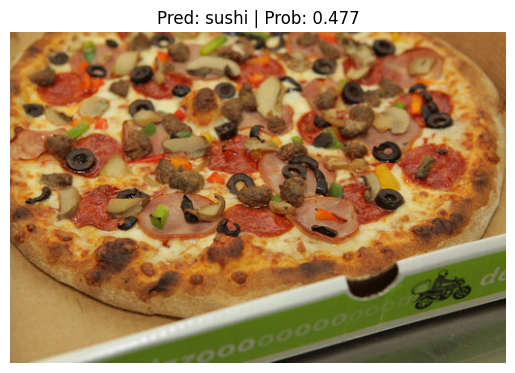

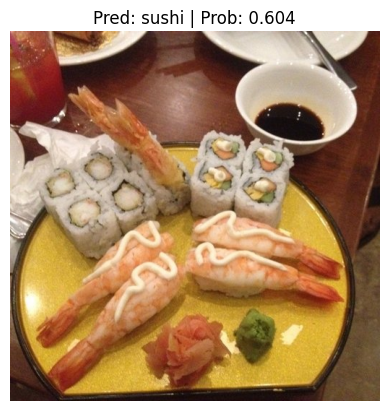

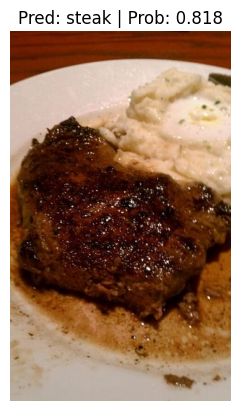

In [22]:
evaluation.pred_and_plot_local_random_images(model=model,
                        test_dir_path=test_dir,
                        class_names=class_names,
                        device=device,
                        transform=weights.transforms())

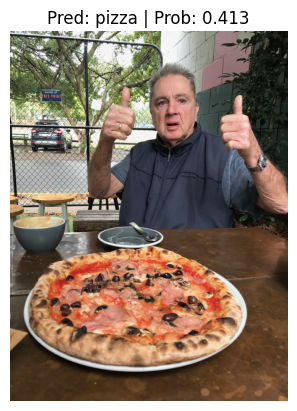

In [23]:
evaluation.pred_on_custom_image_url(model=model,
                                    class_names=class_names,
                                    device=device,
                                    transform=weights.transforms(),
                                    url="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")

Saving Pizza.jpg to Pizza.jpg
Saving sushi.jpeg to sushi.jpeg


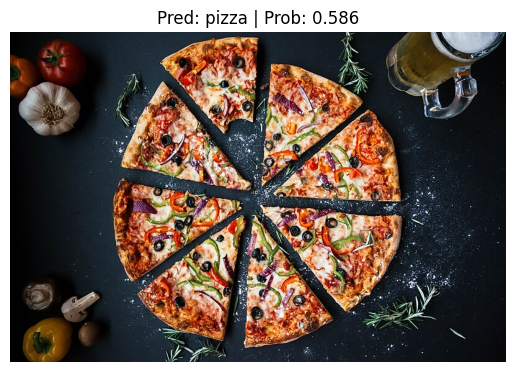

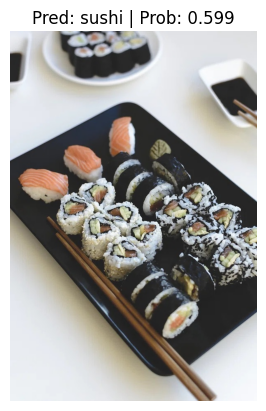

In [24]:
evaluation.pred_and_plot_colab_interface(
    model=model,
    class_names=class_names,
    device=device,
    transform=weights.transforms(),
)

Making Predictions:   0%|          | 0/3 [00:00<?, ?it/s]

{'model_name': 'EfficientNet',
 'model_loss': 0.6261007189750671,
 'model_acc': 0.8666666746139526,
 'model_precision': 0.8666666746139526,
 'model_recall': 0.8666666746139526,
 'model_fl_score': 0.8666666746139526,
 'model_confusion_matrix': array([[21,  1,  3],
        [ 0, 16,  3],
        [ 1,  2, 28]])}

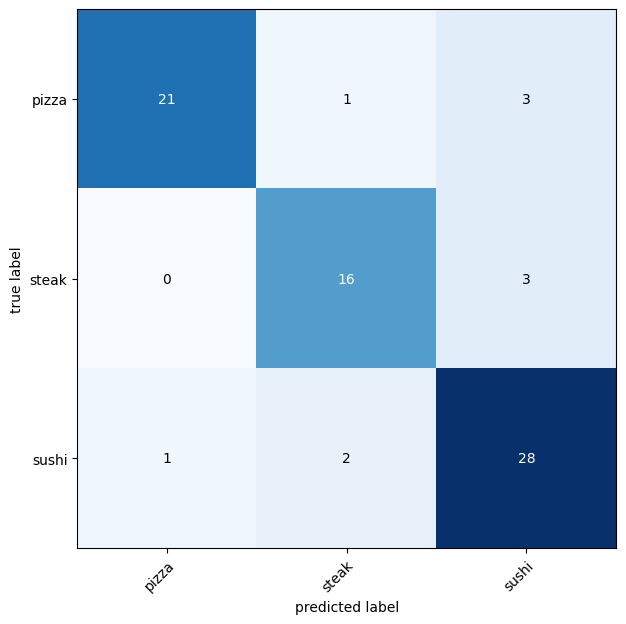

In [25]:
evaluation.evaluate_model_metrics(
    model=model,
    test_dataloader=test_dataloader,
    device=device,
    class_names=class_names,
    task="multiclass",
    loss_fn=loss_fn
)

In [26]:
report = evaluation.evaluate_classification_report(
    model=model,
    test_dataloader=test_dataloader,
    device=device,
    class_names=class_names,
    task="multiclass"
)

print(report)

Making Predictions:   0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       pizza       0.95      0.84      0.89        25
       steak       0.84      0.84      0.84        19
       sushi       0.82      0.90      0.86        31

    accuracy                           0.87        75
   macro avg       0.87      0.86      0.87        75
weighted avg       0.87      0.87      0.87        75



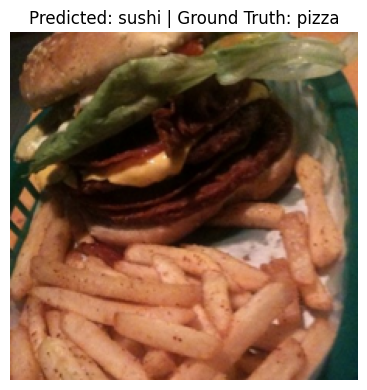

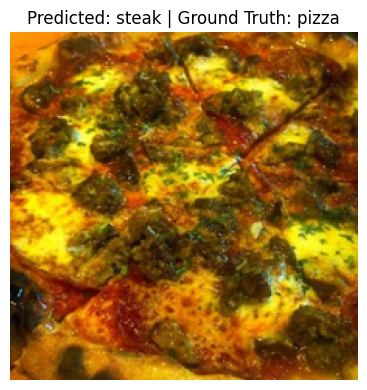

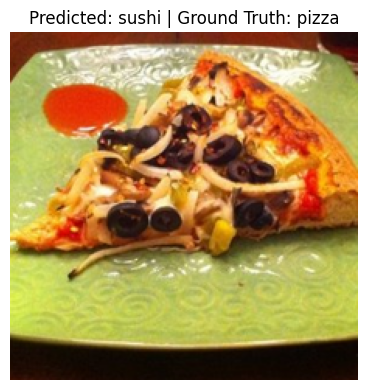

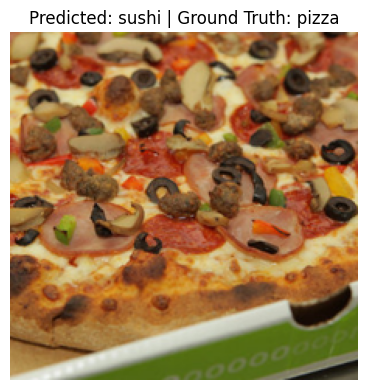

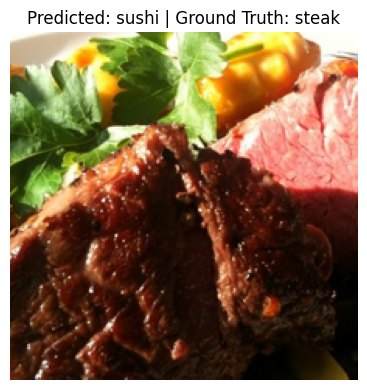

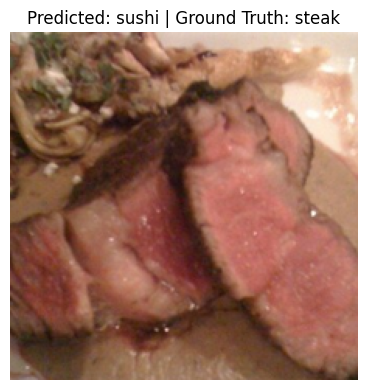

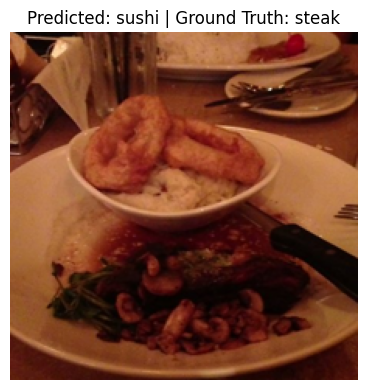

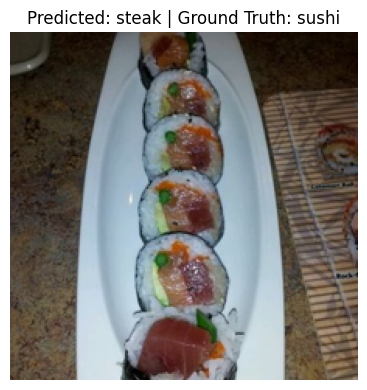

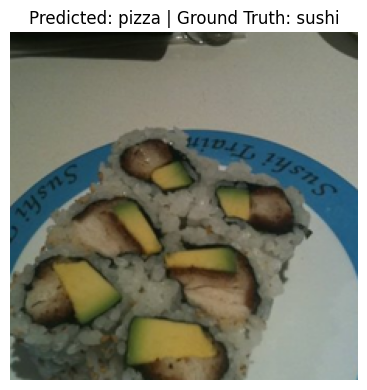

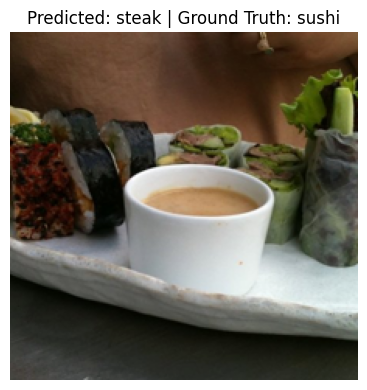

In [27]:
failed_image_gen = evaluation.failed_image_generator(
    model,
    test_dataloader,
    device,
    task="multiclass",
    threshold=0.5
)
evaluation.plot_failed_images_from_generator(
    failed_image_gen,
    class_names,
    transform=auto_transforms,
    max_images=10
)

In [28]:
print("Happy building models, end of notebook")

Happy building models, end of notebook
